In [79]:
library(dplyr)
library(tidyr)
library(igraph)
library(igraph)
library(readr)
library(networkD3)
library(stringr)
library(ggplot2)
library(RColorBrewer)  # Asegúrate de tener este paquete
library(viridis)

In [80]:
# Cargar el archivo CSV (ajusta la ruta y nombre del archivo)
archivo <- "/home/usuario/INSUF/scopus_insuf.csv"
datos <- read_csv(archivo)

Rows: 2382 Columns: 31
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (27): Authors, Author full names, Author(s) ID, Title, Source title, Vol...
dbl  (4): Year, Page count, Cited by, PubMed ID

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [81]:
# Definir una función para extraer los países de una afiliación
extraer_paises <- function(afiliaciones) {
  # Separar las afiliaciones por punto y coma
  partes <- str_split(afiliaciones, ";")[[1]]
  
  # Extraer el país de cada parte
  paises <- str_extract(partes, "[A-Z][a-z]+(?: [A-Z][a-z]+)*$")  # Extraer el último nombre que se considera el país
  return(na.omit(unique(trimws(paises))))  # Retornar países únicos, eliminando NA y espacios en blanco
}

# Aplicar la función a todas las afiliaciones
paises_extraidos <- sapply(datos$Affiliations, extraer_paises)

# Convertir la lista resultante en un vector plano
paises_vector <- unique(unlist(paises_extraidos))

In [82]:
names(paises_extraidos) <- NULL

In [83]:
# Supongamos que `funct_extrac_afiliation` es una función que extrae afiliaciones
# y devuelve un vector de caracteres con los países.
datos$paises <- paises_extraidos

# Convertir la lista de países en un dataframe expandido
datos_expandidos <- datos %>%
  unnest(paises) %>%  # Expandir la lista de países
  mutate(paises = trimws(paises))  # Opcional: eliminar espacios en blanco alrededor de los nombres de países

# Ver el resultado
class(datos_expandidos)

[1] "tbl_df"     "tbl"        "data.frame"

In [84]:
# Convertir en dataframe
datos_df <- as.data.frame(datos_expandidos)

In [85]:
# Lista de términos que quieres eliminar
palabras_no_deseadas <- c("Eye Diseases","Shanghai Key Clinical Specialty","Ocular Fundus Diseases",
                          "Photomedicine","Second Affiliated Hospital","Health","Medical Sciences",
                          "Molecular Medicine","Neuroscience","Regenerative Biology","Disease",
                          "Friedman Brain Institute","Representative","Clinical Practice Guidelines Liaison",
                          "Performance Measures Representative","Md","Pa","Pulmonology","Clinical Chemistry",
                          "Cardiology","Education","Cardiovascular Center","Psychiatry Research","Wisconsin Biotechnology Center",
                          "Research Unit","Ravi Manjithaya","Inserm","Medicine","Microbiome","Patient Safety","Swedish Medical Center",
                          "Providence Health Services","Mount Sinai Heart","Campus Universitario Centro Metropolitano",
                         "Patient Safety", "Geisinger Obesity Institute", "tient Safety")

# Eliminar los términos de la columna 'paises'
datos_df <- datos_df %>%
  mutate(paises = str_replace_all(paises, paste(palabras_no_deseadas, collapse = "|"), ""))

In [86]:
datos_df$paises[which(datos_df$paises == "kistan")] <- "Pakistan"
datos_df$paises[which(datos_df$paises == "Birmingham")] <- "United Kingdom"
datos_df$paises[which(datos_df$paises == "Cambridge")] <- "United Kingdom"
datos_df$paises[which(datos_df$paises == "New York")] <- "United States"
datos_df$paises[which(datos_df$paises == "South Carolina")] <- "United States"
datos_df$paises[which(datos_df$paises == "Puerto Rico")] <- "United States"
datos_df$paises[which(datos_df$paises == "Boston")] <- "United States"
datos_df$paises[which(datos_df$paises == "Washington")] <- "United States"
datos_df$paises[which(datos_df$paises == "Chicago")] <- "United States"
datos_df$paises[which(datos_df$paises == "San Antonio")] <- "United States"
datos_df$paises[which(datos_df$paises == "Florida")] <- "United States"
datos_df$paises[which(datos_df$paises == "Phoenix")] <- "United States"
datos_df$paises[which(datos_df$paises == "Iowa")] <- "United States"
datos_df$paises[which(datos_df$paises == "Rochester")] <- "United States"
datos_df$paises[which(datos_df$paises == "La Crosse")] <- "United States"
datos_df$paises[which(datos_df$paises == "Houston")] <- "United States"
datos_df$paises[which(datos_df$paises == "Danville")] <- "United States"
datos_df$paises[which(datos_df$paises == "Macao")] <- "China"
datos_df$paises[which(datos_df$paises == "Nevis")] <- "Saint Kitts and Nevis"
datos_df$paises[which(datos_df$paises == "lestine")] <- "Palestine"

In [87]:
# Calcular las colaboraciones entre países y su frecuencia
colaboraciones <- datos_df %>%
  filter(!is.na(paises)) %>%      # Filtrar los casos sin países
  unnest(paises) %>%              # Separar los países
  group_by(Title) %>%             # Agrupar por título de artículo
  summarize(
    colaboraciones = list({
      unique_paises <- unique(paises)
      if (length(unique_paises) >= 2) {
        combn(unique_paises, 2, simplify = FALSE)
      } else {
        NULL
      }
    })
  ) %>%
  filter(!sapply(colaboraciones, is.null)) %>% # Filtrar combinaciones nulas
  unnest(colaboraciones)

# Convertir los pares en un dataframe adecuado para un grafo
edges <- do.call(rbind, colaboraciones$colaboraciones)
colnames(edges) <- c("Pais1", "Pais2")

# Ordenar alfabéticamente los nombres de los países para evitar duplicados
edges_sorted <- data.frame(
  Pais1 = pmin(edges[,1], edges[,2]),
  Pais2 = pmax(edges[,1], edges[,2])
)

# Contar las ocurrencias de cada par de países
edges_count <- edges_sorted %>%
  group_by(Pais1, Pais2) %>%  # Agrupar por las columnas
  summarise(Count = n()) %>%  # Contar las ocurrencias
  arrange(desc(Count))         # Ordenar por el conteo en orden descendente

`summarise()` has grouped output by 'Pais1'. You can override using the `.groups` argument.


In [92]:
# Crear el grafo
grafo <- graph_from_data_frame(d=edges_count[1:20,], directed=FALSE)

# Crear una función para simular el efecto 3D en los nodos
add_shadow <- function(colors, intensity = 0.8) {
  # Hacer que los bordes sean más oscuros para simular un efecto de sombra
  darker_colors <- adjustcolor(colors, intensity)
  return(darker_colors)
}

# Asignar colores de los nodos
vertex_colors <- "lightgreen"
vertex_border_colors <- add_shadow(vertex_colors)

# Definir el layout para mayor separación
layout <- layout_with_fr(grafo)

png("/home/usuario/INSUF/insuf_grafo_scopus.png", width = 2000, height = 1500, res = 300)  # Ajusta width, height y res según tus necesidades
# Visualizar el grafo con efecto de sombra (simulando 3D)
plot(grafo, 
     layout = layout,                  # Usar el layout definido
     vertex.label = V(grafo)$name, 
     vertex.size = 30,                 # Tamaño de los nodos
     vertex.color = vertex_colors,     # Color de los nodos
     vertex.frame.color = vertex_border_colors, # Bordes más oscuros para simular 3D
     edge.width = 1,
     vertex.label.color = "black",     # Color de las etiquetas
     vertex.label.cex = 0.8,           # Tamaño de las etiquetas
     vertex.label.font = 2             # Negrita
)
dev.off()

pdf 
  2

In [89]:
# Pasamos a caracteres la lista de países
datos_df$paises <- paste(datos_df$paises)

# Suponiendo que tu dataframe se llama 'df'
# Agrupar por 'Year' y 'paises' y contar el número de publicaciones
df_summary <- datos_df %>%
  group_by(Year, paises) %>%
  summarise(Production = n(), .groups = 'drop')  # Contar el número de publicaciones

# Ver los datos resumidos
print(df_summary)


# A tibble: 627 × 3
    Year paises         Production
   <dbl> <chr>               <int>
 1  2014 Argentina               1
 2  2014 Australia              10
 3  2014 Austria                 1
 4  2014 Belgium                 3
 5  2014 Brazil                 22
 6  2014 Canada                  7
 7  2014 China                  17
 8  2014 Colombia                1
 9  2014 Czech Republic          2
10  2014 Denmark                 1
# ℹ 617 more rows


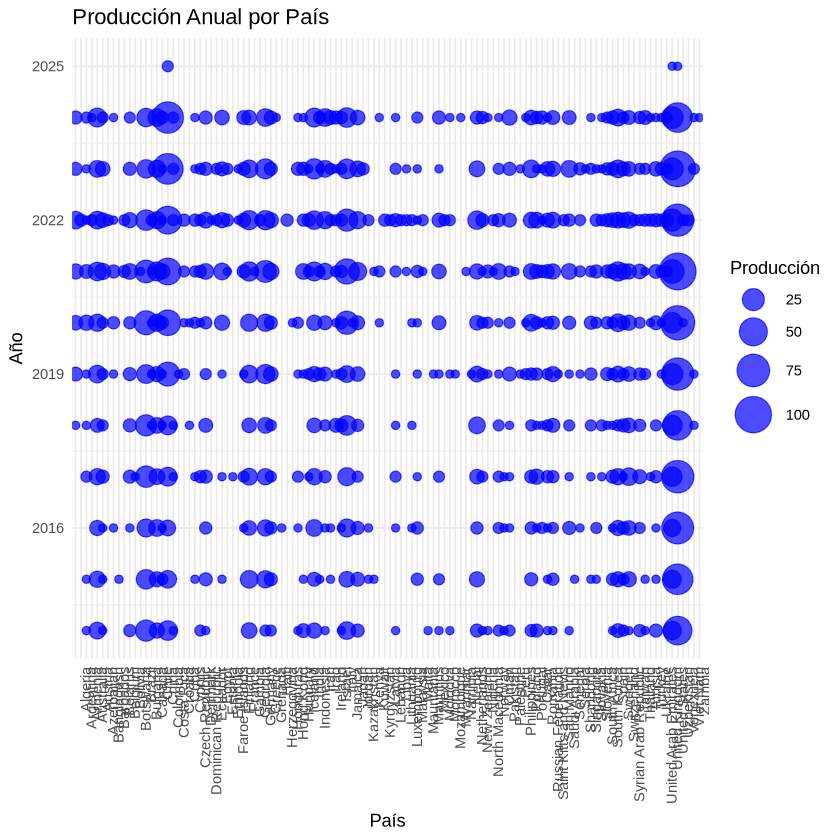

In [90]:
# Crear el gráfico con un color fijo
ggplot(df_summary, aes(x = paises, y = Year, size = Production)) +
  geom_point(alpha = 0.7, color = "blue") +  # Ajusta el color de los puntos
  scale_size(range = c(2, 10), name = "Producción") +  # Ajusta el rango del tamaño de los puntos
  labs(title = "Producción Anual por País",
       x = "País",
       y = "Año") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))  # Ajustar el ángulo del texto del eje x

In [91]:
png("/home/usuario/INSUF/insuf_burbuja_scopus.png", width = 2500, height = 2500, res = 300)  # Ajusta width, height y res según tus necesidades
df_summary %>% 
  filter(Production > 5) %>% 
  ggplot(aes(x = paises, y = Year, size = Production, color = paises)) +  
  geom_point(alpha = 0.7, show.legend = FALSE) +  # Quitar la leyenda de los países
  scale_size(range = c(2, 10), name = "Producción") + 
  labs(title = "",
       x = "País",
       y = "Año") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, size = 14),  # Aumentar tamaño del texto del eje x
    axis.text.y = element_text(size = 14),  # Aumentar tamaño del texto del eje y
    axis.title.x = element_text(size = 14),  # Aumentar tamaño del título del eje x
    axis.title.y = element_text(size = 14)   # Aumentar tamaño del título del eje y
  ) + 
  scale_color_viridis_d() +  # Usar la paleta viridis para más colores
  scale_y_continuous(breaks = seq(floor(min(df_summary$Year)), ceiling(max(df_summary$Year)), by = 1))  # Eje y solo con enteros
dev.off()

pdf 
  2